# Project Histology Tissue Classification Project - Data exploration

## Goal

For this project we have:
- input colors images 
- a limited sample (5'000)
- Deep Learning know how
- no knowledge about Histology Tissue (this will be to define which feature is important: color, location, density, ...)
- limited resources (old Mac OS, option is to use Colab or GCP but require some refactoring of the code)

Following the above requirement and know how:
- use CNN model because it is translation invariant
- use Keras to focus on the modeling part and not have too long notebook (it is quite straight forward to write it with low lever Tensorflow ops)
- see if limited sample and model complexity doesn't give model that overfit too much
- metrics, ROC curve and confusion matrix
- try pre-trained model: Transfert Learning ( to see if we can balanced the small amount of data we have
- hyperparameter tuning but we need GCP because one model can take 6 hours to run!
- use Lime for model interpretation


## To-do list

The main limitation are compute power and data

Use data augmentation:
- use the current images, crop them, rotate them to generate a bigger samples
- use image transformation to hight some feature in such images (need Histology Tissue know how)

Compute power: use Colab or GCP:
- use tf.estimator to be able to train the model on Cloud ML-engine
- use tf.data.dataset to be able to use multiple CPU for transformation and only load mini batch images in memory
- use tf.contrib.strategy to use GPU and TPU

Other items:
- use SHAP for model interpretation
- overlap prediction and original images
- other pre-trained model ResNet wih less parameter
- add diagrams CNN
- explain the strategy for various CNN models

## Add this dataset in TensorFlow 2.00: AI for Good

Please vote to have this dataset available in TensorFlow 2.0:
https://github.com/tensorflow/datasets/issues/49

## Import needed packages

In [152]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

In [2]:
tf.__version__

'1.12.0'

## Data exploration
### Helper function for Pandas

In [3]:
def pandas_display():
    """
    Function to setup pandas parameters for interactive session for better display of the DataFrame.

    Returns
    -------
    None
    """

    options = {
        'display': {
            'max_columns': 550,
            'width': 3000,
            'max_colwidth': -1,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 200,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            print('{}.{}'.format(category, op), value)
            pd.set_option('{}.{}'.format(category, op), value)

In [4]:
pandas_display()

display.max_columns 550
display.width 3000
display.max_colwidth -1
display.expand_frame_repr False
display.max_rows 200
display.max_seq_items 50
display.precision 4
display.show_dimensions False
mode.chained_assignment None


### Data extraction

In [5]:
base_dir = 'data/kather_texture_2016_image_tiles_5000'

In [6]:
df = pd.DataFrame({'path': glob(os.path.join(base_dir, '*', '*.tif'))})

In [7]:
df['file_id'] = df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x))) 
df['cell_type_idx'] = df['cell_type'].map(lambda x: int(x.split('_')[0]))
df['cell_type'] = df['cell_type'].map(lambda x: x.split('_')[1])
df['full_image_name'] = df['file_id'].map(lambda x: x.split('_Row')[0])
df['full_image_row'] = df['file_id'].map(lambda x: int(x.split('_')[-3]))
df['full_image_col'] = df['file_id'].map(lambda x: int(x.split('_')[-1]))

In [8]:
df['image'] = df['path'].map(imread)

In [9]:
df.to_pickle('./data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

reading data from the pkl file

In [10]:
pd.__version__

'0.23.4'

In [11]:
df=pd.read_pickle('./data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

In [14]:
df.describe(exclude=[np.number])

path                                   file_id cell_type               full_image_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [15]:
df.head()

path                                         file_id cell_type  cell_type_idx                full_image_name  full_image_row  full_image_col                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [16]:
df.sample(3)

path                                         file_id cell_type  cell_type_idx               full_image_name  full_image_row  full_image_col                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [17]:
df.dtypes

path               object
file_id            object
cell_type          object
cell_type_idx      int64 
full_image_name    object
full_image_row     int64 
full_image_col     int64 
image              object
dtype: object

### Checking missing values

In [18]:
df.isnull().sum()

path               0
file_id            0
cell_type          0
cell_type_idx      0
full_image_name    0
full_image_row     0
full_image_col     0
image              0
dtype: int64

In [19]:
df['cell_type'].unique()

array(['STROMA', 'MUCOSA', 'DEBRIS', 'TUMOR', 'COMPLEX', 'EMPTY',
       'LYMPHO', 'ADIPOSE'], dtype=object)

In [20]:
df.memory_usage(deep=True).sum()/1024**2

2.6891908645629883

In [21]:
 df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
path               5000 non-null object
file_id            5000 non-null object
cell_type          5000 non-null object
cell_type_idx      5000 non-null int64
full_image_name    5000 non-null object
full_image_row     5000 non-null int64
full_image_col     5000 non-null int64
image              5000 non-null object
dtypes: int64(3), object(5)
memory usage: 2.7 MB


In [22]:
len(df), len(df.columns)

(5000, 8)

In [23]:
df.shape

(5000, 8)

### Checking if we have imbalanced classes

In [24]:
df['cell_type'].value_counts()

ADIPOSE    625
COMPLEX    625
MUCOSA     625
DEBRIS     625
LYMPHO     625
STROMA     625
TUMOR      625
EMPTY      625
Name: cell_type, dtype: int64

### Checking duplicates

In [25]:
df['full_image_name'][df['full_image_name'].duplicated()]

3542    140E1_CRC-Prim-HE-06_005.tif
3665    1411C_CRC-Prim-HE-06_005.tif
3742    14AD7_CRC-Prim-HE-06_005.tif
4229    15EA0_CRC-Prim-HE-01_013.tif
4972    16193_CRC-Prim-HE-05_032.tif
Name: full_image_name, dtype: object

In [66]:
df['full_image_name'][df['full_image_name'].duplicated()].index

Int64Index([3542, 3665, 3742, 4229, 4972], dtype='int64')

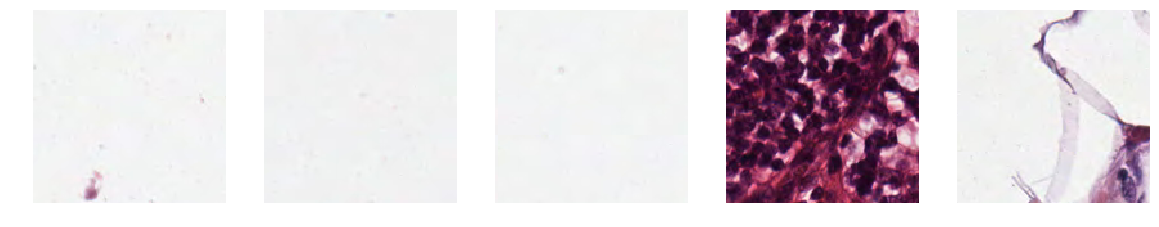

In [114]:
n_samples = 5
fig, m_axs = plt.subplots(1, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, idx in zip(m_axs, df['full_image_name'][df['full_image_name'].duplicated()].index):
    n_axs.imshow(df.iloc[int(idx)]['image'])
    n_axs.axis('off')

## Data visualization of some examples

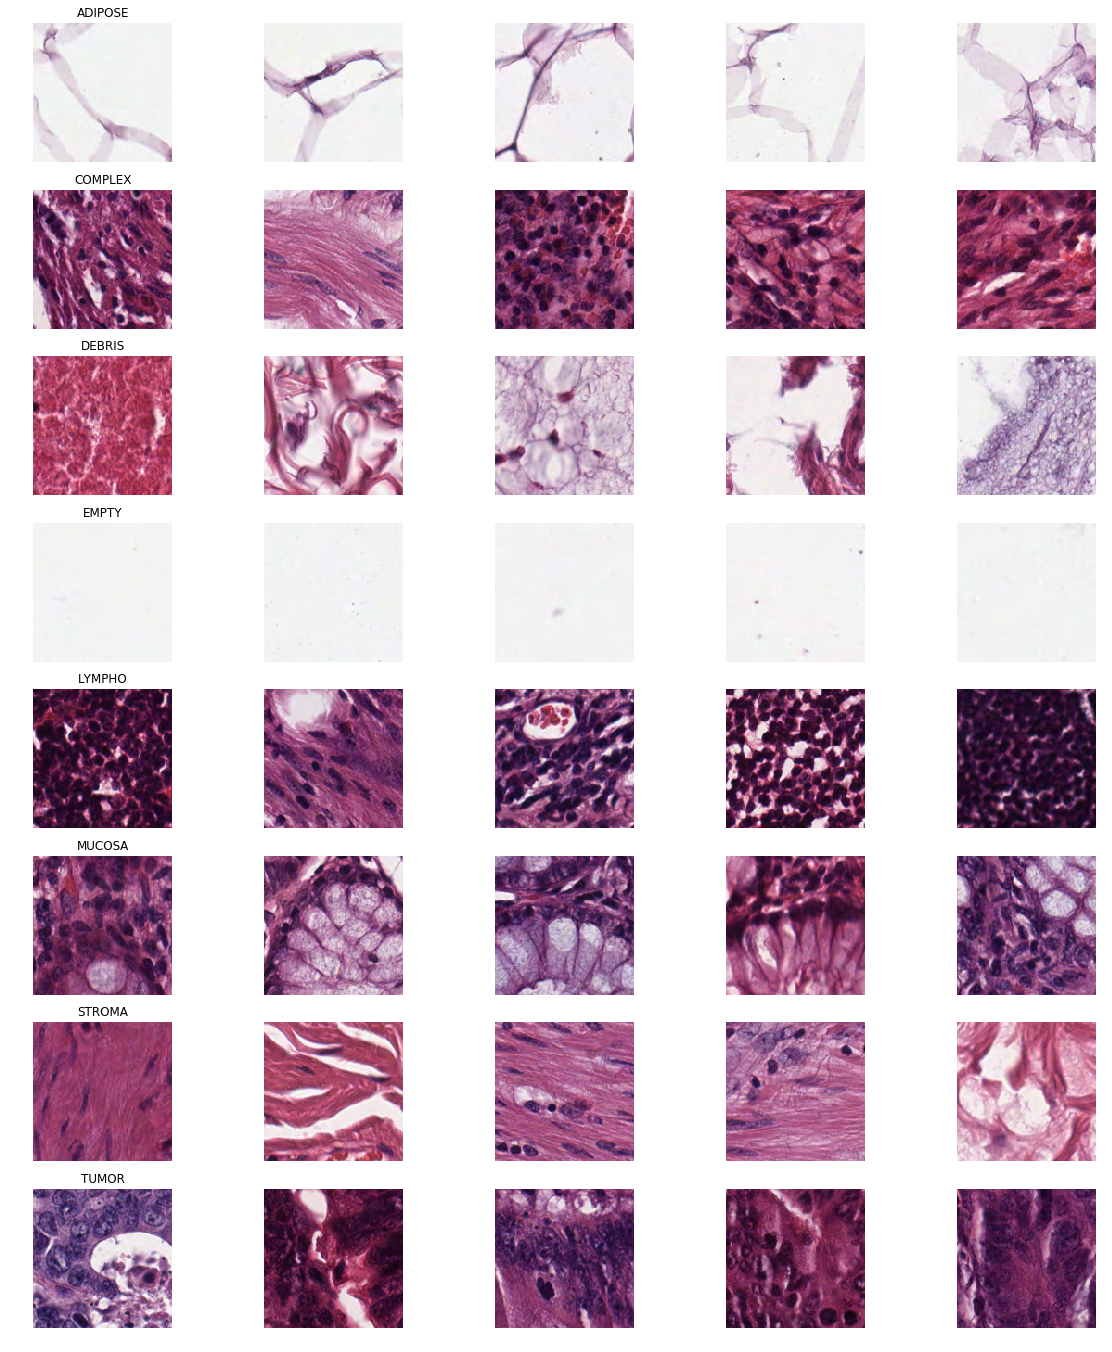

In [115]:
n_samples = 5
fig, m_axs = plt.subplots(8, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

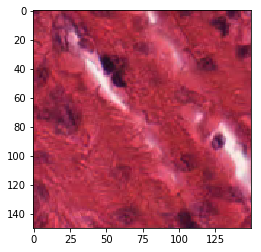

In [116]:
plt.imshow(df['image'][0]);

In [117]:
df['image'][0].shape

(150, 150, 3)

In [118]:
df['image'][0].dtype

dtype('uint8')

## Reshuffling of the data

In [119]:
df[['path', 'file_id', 'cell_type', 'cell_type_idx', 'full_image_name', 'full_image_row', 'full_image_col']].head(5)

,path,file_id,cell_type,cell_type_idx,full_image_name,full_image_row,full_image_col
0,data/kather_texture_2016_image_tiles_5000/02_STROMA/14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151.tif,14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151,STROMA,2,14389_CRC-Prim-HE-07_026.tif,751,151
1,data/kather_texture_2016_image_tiles_5000/02_STROMA/1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201.tif,1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201,STROMA,2,1163A_CRC-Prim-HE-05_009b.tif,751,1201
2,data/kather_texture_2016_image_tiles_5000/02_STROMA/118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif,118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601,STROMA,2,118E_CRC-Prim-HE-02_015.tif,301,3601
3,data/kather_texture_2016_image_tiles_5000/02_STROMA/12238_CRC-Prim-HE-09.tif_Row_151_Col_2551.tif,12238_CRC-Prim-HE-09.tif_Row_151_Col_2551,STROMA,2,12238_CRC-Prim-HE-09.tif,151,2551
4,data/kather_texture_2016_image_tiles_5000/02_STROMA/100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301.tif,100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301,STROMA,2,100A6_CRC-Prim-HE-02_029.tif,601,301


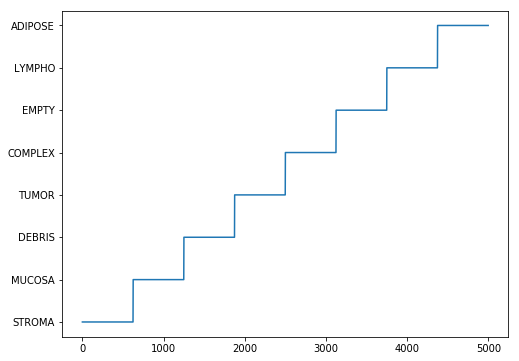

In [120]:
plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.show()

In [121]:
max(df.index.values), min(df.index.values)

(4999, 0)

In [122]:
import random
rows = df.index.values
random.shuffle(rows)
rows

array([1662, 3492, 4441, ..., 2133, 4707, 4884])

In [123]:
max(rows), min(rows)

(4999, 0)

In [124]:
sum(df.index.values)

12497500

In [125]:
sum(rows)

12497500

In [126]:
df=df.reindex(rows)
df.sort_index(inplace=True)

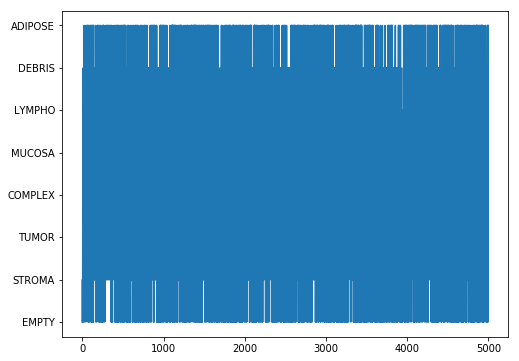

In [127]:
plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.show()

In [129]:
df['cell_type'][0:10]

0    EMPTY  
1    STROMA 
2    EMPTY  
3    EMPTY  
4    TUMOR  
5    COMPLEX
6    STROMA 
7    MUCOSA 
8    COMPLEX
9    EMPTY  
Name: cell_type, dtype: object

## Preparing the features and the labels
### One hot encoding of the labels

In [130]:
df_label = pd.get_dummies(df['cell_type'])

In [131]:
df_label.head()

,ADIPOSE,COMPLEX,DEBRIS,EMPTY,LYMPHO,MUCOSA,STROMA,TUMOR
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1


In [132]:
dict_label=list(df_label.columns)
dict_label

['ADIPOSE',
 'COMPLEX',
 'DEBRIS',
 'EMPTY',
 'LYMPHO',
 'MUCOSA',
 'STROMA',
 'TUMOR']

In [133]:
label=df_label.values

In [134]:
label.shape, label.dtype

((5000, 8), dtype('uint8'))

In [135]:
label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Selection of the features: pixels of the images

In [136]:
data=np.array(df['image'].tolist())

In [137]:
data.shape, data.dtype

((5000, 150, 150, 3), dtype('uint8'))

## Split Training/Validation/Testing datasets

### Split for Training/Validation/Testing

In [139]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [140]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


### Cast of the input pixels

In [142]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_val = np.array( x_val, dtype=np.float32)

In [144]:
np.amax(x_train), np.amax(x_test), np.amax(x_val)

(255.0, 255.0, 255.0)

In [145]:
np.amin(x_train), np.amin(x_test), np.amin(x_val)

(0.0, 0.0, 0.0)

### Normalization of the input pixels in the 3 channels

In [146]:
x_train /= 255
x_test /= 255
x_val /= 255

In [147]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_val shape:', x_val.shape)

x_train shape: (3000, 150, 150, 3)
x_test shape: (1000, 150, 150, 3)
x_val shape: (1000, 150, 150, 3)


### Saving the data as pickle files

In [161]:
pickle.dump(x_train, open('./data/x_train.pkl', 'wb'))
pickle.dump(x_test, open('./data/x_test.pkl', 'wb'))
pickle.dump(x_val, open('./data/x_val.pkl', 'wb'))

In [162]:
pickle.dump(y_train, open('./data/y_train.pkl', 'wb'))
pickle.dump(y_test, open('./data/y_test.pkl', 'wb'))
pickle.dump(y_val, open('./data/y_val.pkl', 'wb'))